In [87]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch 
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.io import loadmat
from dataset import Data
from math import log10
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,10)

{'x': tensor([[[[0.0982, 0.0662, 0.1091,  ..., 0.0518, 0.1091, 0.0662],
          [0.1006, 0.0671, 0.0960,  ..., 0.0628, 0.0980, 0.0682],
          [0.1028, 0.0672, 0.0957,  ..., 0.0496, 0.1055, 0.0709],
          ...,
          [0.0382, 0.0221, 0.0283,  ..., 0.1294, 0.0391, 0.0226],
          [0.0350, 0.0202, 0.0430,  ..., 0.1177, 0.0377, 0.0287],
          [0.0439, 0.0248, 0.0443,  ..., 0.1301, 0.0443, 0.0248]]]],
       dtype=torch.float64), 'y': tensor([[[[0.1437, 0.1604, 0.0924,  ..., 0.2031, 0.0924, 0.1604],
          [0.1348, 0.1440, 0.0813,  ..., 0.2109, 0.0810, 0.1621],
          [0.1451, 0.1547, 0.0748,  ..., 0.2068, 0.0944, 0.1596],
          ...,
          [0.0817, 0.0439, 0.0505,  ..., 0.1744, 0.0478, 0.0462],
          [0.0768, 0.0557, 0.0423,  ..., 0.1556, 0.0474, 0.0354],
          [0.0742, 0.0501, 0.0499,  ..., 0.1679, 0.0499, 0.0501]]]],
       dtype=torch.float64)}
torch.Size([127, 61])
torch.Size([127, 62])


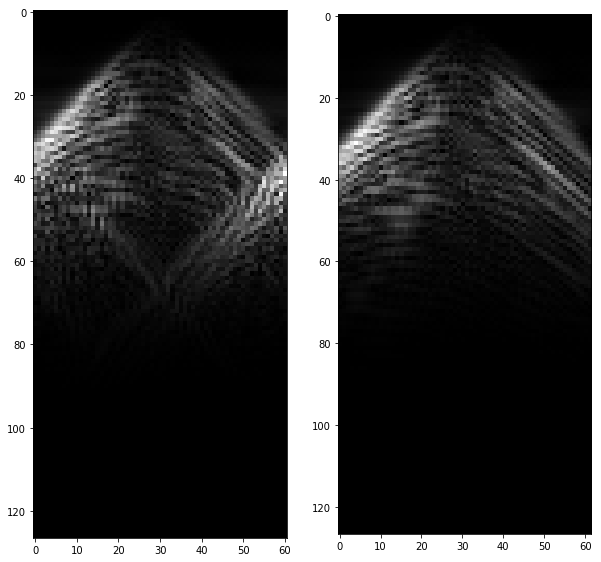

In [106]:
batch_size = 1
is_fk = True
if is_fk:
    filename_x='data_fk_25'
    filename_y='data_fk_125'
else: 
    filename_x='data_25'
    filename_y='data_125'
#load the data
data = Data(filename_x=filename_x, filename_y=filename_y)
#split the data
train_data, test_data = random_split(data, [1,60])
#put the train set into dataloader

train_dataloader = DataLoader(train_data, batch_size = batch_size, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size = 1, drop_last=True)

for batch in train_dataloader:
    print(batch)
    print(batch['x'][0].squeeze(0).shape)
    print(batch['y'][0].squeeze(0).shape)
    plt.subplot(1, 2, 1)
    plt.imshow(batch['x'][0].squeeze(0),cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(batch['y'][0].squeeze(0),cmap='gray')
    plt.show()
    break

In [54]:

#overview of different models
# model described here http://personal.ie.cuhk.edu.hk/~ccloy/files/eccv_2014_deepresolution.pdf

class SRCNN(nn.Module):
    """Basic benchmark model, paper introducing the model is http://personal.ie.cuhk.edu.hk/~ccloy/files/eccv_2014_deepresolution.pdf"""
    def __init__(self, latent_dim= [64,32], input_dim = (251,61) , output_dim = [251,121] ):
        super(SRCNN, self).__init__()
        self.output_dim = output_dim
        self.sequence = nn.Sequential()
        #actually dimensions have to be changed, here's a tutorial http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html
        self.sequence.add_module("Convolution 1", nn.Conv2d(1, latent_dim[0], kernel_size = 9, padding = 4))
        self.sequence.add_module("ReLU 1", nn.ReLU())
        self.sequence.add_module("Convolution 2", nn.Conv2d(latent_dim[0], latent_dim[1], kernel_size = 1 , padding = 0))
        self.sequence.add_module("ReLU 2", nn.ReLU())
        self.sequence.add_module("Convolution 3", nn.Conv2d(latent_dim[1], 1, kernel_size = 5 , padding = 2))
    
    def forward(self, x):
        x_interpolated = nn.functional.interpolate(x, size=self.output_dim)
        
        return self.sequence(x_interpolated)




In [109]:
class Residual_Block(nn.Module): 
    def __init__(self, feature_dim, kernel_size, rescale = 1):
        super(Residual_Block, self).__init__()
        self.block = nn.Sequential()
        self.block.add_module("Convolution 1", nn.Conv2d(feature_dim , feature_dim, kernel_size = kernel_size,  stride=1, padding=1))
        self.block.add_module("ReLU", nn.ReLU())
        self.block.add_module("Convolution 2", nn.Conv2d(feature_dim , feature_dim, kernel_size = kernel_size,  stride=1, padding=1))
        self.rescale = rescale
    def forward(self, x):
        out = self.block(x)
        out *= self.rescale
        out += x
        return out

class EDSR(nn.Module):
    def __init__(self, latent_dim= 256, n_resblocks = 32, rescale = 1, output_dim  = [251,121]):
        super(EDSR, self).__init__()
        self.output_dim = output_dim
        kernel_size = 3 
        #input convolution, output of this will be added
        self.conv_first =  nn.Conv2d(1 ,latent_dim, kernel_size = kernel_size, stride=1, padding=1)
        #resblocks block 
        self.blocks = nn.Sequential()
        
        for res in range(n_resblocks):
            self.blocks.add_module("Resblock {}".format(res), Residual_Block(latent_dim, kernel_size, rescale))
        
        #intermideate convolution
        self.conv_inter = nn.Conv2d(latent_dim, latent_dim, kernel_size = kernel_size, stride = 1 ,padding = 1)
        
        #upscaling 
        
        
       
        """
        Input: (N,C∗upscale_factor2,H,W)
        Output: (N,C,H∗upscale_factor,W∗upscale_factor)
        """
        upscale = 4
        self.upscale = nn.Sequential(
            nn.Conv2d(in_channels=latent_dim, out_channels=latent_dim*upscale, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PixelShuffle(2),
            nn.Conv2d(in_channels=latent_dim, out_channels=latent_dim*upscale, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PixelShuffle(2),
        )
        #last convolution
        self.conv_last = nn.Conv2d(latent_dim , 1 , kernel_size=kernel_size, stride = 1, padding = 1)
    
    def forward(self, x):
        x = nn.functional.interpolate(x, size=self.output_dim)
        image_processed = self.conv_first(x)
        out = self.blocks(image_processed)
        out += x
        #out = self.upscale(out)
        out = self.conv_last(out)
        
        return out

Epoch 0, loss 740.1661376953125, psnr -28.693292124147717 dB
Epoch 1, loss 98762464.0, psnr -79.9459191649941 dB
Epoch 2, loss 59811976.0, psnr -77.76788150376001 dB
Epoch 3, loss 64714.921875, psnr -48.11004431221774 dB
Epoch 4, loss 53374.75, psnr -47.27335853862125 dB
Epoch 5, loss 44739.9921875, psnr -46.5069590392409 dB
Epoch 6, loss 109712.03125, psnr -50.40254255824273 dB
Epoch 7, loss 83494.2890625, psnr -49.21656771130745 dB
Epoch 8, loss 104540.4140625, psnr -50.19284215913853 dB
Epoch 9, loss 85763.6328125, psnr -49.33303168769024 dB
Epoch 10, loss 43249.00390625, psnr -46.35976109419313 dB
Epoch 11, loss 15279.0595703125, psnr -41.840966241354224 dB
Epoch 12, loss 32833.72265625, psnr -45.16320125416283 dB
Epoch 13, loss 14640.0859375, psnr -41.65543626044265 dB
Epoch 14, loss 12410.7197265625, psnr -40.937969679782604 dB
Epoch 15, loss 13242.3310546875, psnr -41.21964440925362 dB
Epoch 16, loss 8115.896484375, psnr -39.093364991115024 dB
Epoch 17, loss 7091616.5, psnr -68.

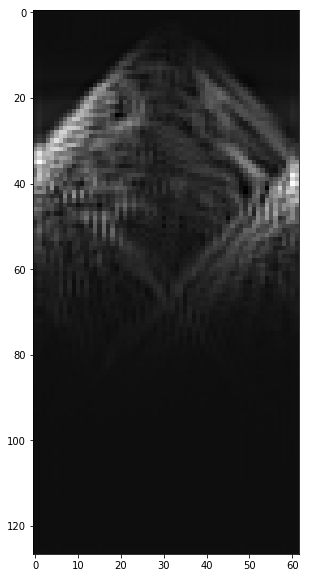

In [110]:
torch.manual_seed(42)
if is_fk:
    output_dim = [127,62]
else:
    output_dim = [251,121]
model = EDSR(n_resblocks = 1, output_dim = output_dim)
optimiser = torch.optim.Adam(params=model.parameters(), lr = 1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimiser, step_size=1)
loss_function = nn.MSELoss()
def training(model, optimiser, train_dataloader, loss_function = nn.MSELoss(),  epoch_number = 10000, device = 'cpu'):
    model.to(device)
    loss_epoch = []
    psnr_epoch = []
    for epoch in range(epoch_number):
        if epoch == 25:
            pass
            #scheduler.step()
            #print("LR decreases. New lr is {}".format(optimiser.param_groups[0]['lr']))
        loss_list = []
        psnr_list = []
        for batch in train_dataloader:
            
            x = batch["x"].to(device =device).float()
            y = batch["y"].to(device =device).float()
            model.train()
            optimiser.zero_grad()
            y_reconstructed = model(x)
            loss = loss_function(y_reconstructed, y)
            loss.backward()
            optimiser.step()
            
            loss_list+=[loss.item()]
            psnr_list+=[10 * log10(1 / loss.item())]
        mean_loss = np.mean(loss_list)
        mean_psnr = np.mean(psnr_list)
        print("Epoch {}, loss {:4}, psnr {} dB".format(epoch,mean_loss ,mean_psnr))
        loss_epoch+=[mean_loss]
        psnr_epoch+=[mean_psnr]
        
    
    plt.imshow(y_reconstructed[0].squeeze(0).detach().numpy(),cmap='gray')
    plt.show()
    
training(model, optimiser, train_dataloader, loss_function = loss_function)

435.13336181640625


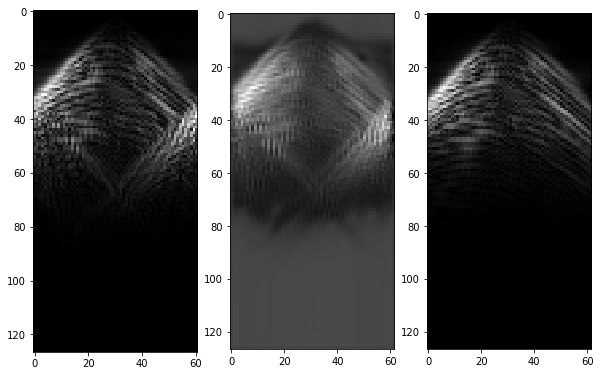

In [108]:
model.eval()
device = 'cpu'
for batch in test_dataloader:
    x = batch["x"].to(device=device).float()
    y = batch["y"].to(device=device).float()
    y_reconstructed = model(x)
    loss = loss_function(y_reconstructed, y)
    print(loss.item())
    plt.subplot(1, 3, 1)
    plt.imshow(x[0].squeeze(0),cmap='gray')
    plt.subplot(1, 3, 2)
    plt.imshow(y_reconstructed[0].squeeze(0).detach().numpy(),cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(y[0].squeeze(0),cmap='gray')
    plt.show()
    